In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#from scipy.stats import describe
import math
import os
import glob
import datetime
import statsmodels.api as sm
import statsmodels.graphics.tsaplots as tsaplots
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
%matplotlib inline
sns.set_theme(style="darkgrid")
### Separate file with functions
execfile("functions/_plot_and_wrangling_functions.py")


In [2]:
glob.glob('../data/*')

['../data\\holidays_events.csv',
 '../data\\oil.csv',
 '../data\\sample_submission.csv',
 '../data\\stores.csv',
 '../data\\test.csv',
 '../data\\train.csv',
 '../data\\transactions.csv']

In [3]:
train_df = pd.read_csv('../data/train.csv')
holidays_df = pd.read_csv('../data/holidays_events.csv')
oil_df = pd.read_csv('../data/oil.csv')
stores_df = pd.read_csv('../data/stores.csv')
transactions_df = pd.read_csv('../data/transactions.csv')
sample_df = pd.read_csv('../data/sample_submission.csv')
test_df = pd.read_csv('../data/test.csv')

##### Understanding Holidays

NOTE: Pay special attention to the transferred column. A holiday that is transferred officially falls on that calendar day, but was moved to another date by the government. A transferred day is more like a normal day than a holiday. To find the day that it was actually celebrated, look for the corresponding row where type is Transfer. For example, the holiday Independencia de Guayaquil was transferred from 2012-10-09 to 2012-10-12, which means it was celebrated on 2012-10-12. Days that are type Bridge are extra days that are added to a holiday (e.g., to extend the break across a long weekend). These are frequently made up by the type Work Day which is a day not normally scheduled for work (e.g., Saturday) that is meant to payback the Bridge.
Additional holidays are days added a regular calendar holiday, for example, as typically happens around Christmas (making Christmas Eve a holiday).

In [4]:
holidays_df.head(1)

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False


In [5]:
holidays_df.query('type == "Transfer"').head(1)

,date,type,locale,locale_name,description,transferred
20,2012-10-12,Transfer,National,Ecuador,Traslado Independencia de Guayaquil,False


In [6]:
### We drop every row where the tranferred == True, since the database already provides a new row to when the holiday was transferred to
### A better approach would test if the transferred holidays have any significant impact compared to regular holidays or create
### a column for each holiday with a boolean value if it is that holiday or not
holidays_df2 = holidays_df[holidays_df['transferred'] == False].copy()

In [7]:
holidays_df2.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [8]:
#### Now we group the dataframe to have only the date, locale and locale_name, which will be our keys for future joins
#### Using this approach, we will create a single column in the training dataframe if is holiday or not
#### Another option would be creating a boolean value per holiday so we can also measure different impacts on the sales
holidays_df3 = (holidays_df2.groupby(['date','locale','locale_name'], as_index = False)['description'].count()
                .sort_values(by = ['description'], ascending= [False]))

In [9]:
holidays_df4 = holidays_df3[['date','locale','locale_name']].drop_duplicates() 

In [10]:
holidays_df4.sort_values(by = 'date')

,date,locale,locale_name
0,2012-03-02,Local,Manta
1,2012-04-01,Regional,Cotopaxi
2,2012-04-12,Local,Cuenca
3,2012-04-14,Local,Libertad
4,2012-04-21,Local,Riobamba
...,...,...,...
326,2017-12-22,National,Ecuador
327,2017-12-23,National,Ecuador
328,2017-12-24,National,Ecuador
329,2017-12-25,National,Ecuador


#### Working with oil dataset

Daily oil price. Includes values during both the train and test data timeframes. (Ecuador is an oil-dependent country and it's economical health is highly vulnerable to shocks in oil prices.)

Since this is a stock information, we need to fill in the days that there is no market trade

In [11]:
print(f'There are {train_df["date"].nunique() + test_df["date"].nunique()} days available in the dataset')
print(f'But there are {(pd.to_datetime(test_df["date"].max()) - pd.to_datetime(train_df["date"].min()))} days between first and last day')

There are 1700 days available in the dataset
But there are 1703 days 00:00:00 days between first and last day


In [12]:
#### We create a dataframe with the first day available in the train_df and with the last day of test_df and set the freq to daily
totaldays = pd.DataFrame({'date': pd.date_range(start = train_df['date'].min(), end = test_df['date'].max())})
totaldays['date'].freq = 'd'

In [13]:
oil_df['date'] = pd.to_datetime(oil_df['date'])

In [14]:
#### Merge the two dataframes and do a backward fill to get the correct values of the day
#### then we transform the column to datetime format. Now we can plot and understand the data
oil_df2 = totaldays.merge(oil_df, how = 'left', on = 'date').bfill()
oil_df2['date'] = pd.to_datetime(oil_df2['date'])

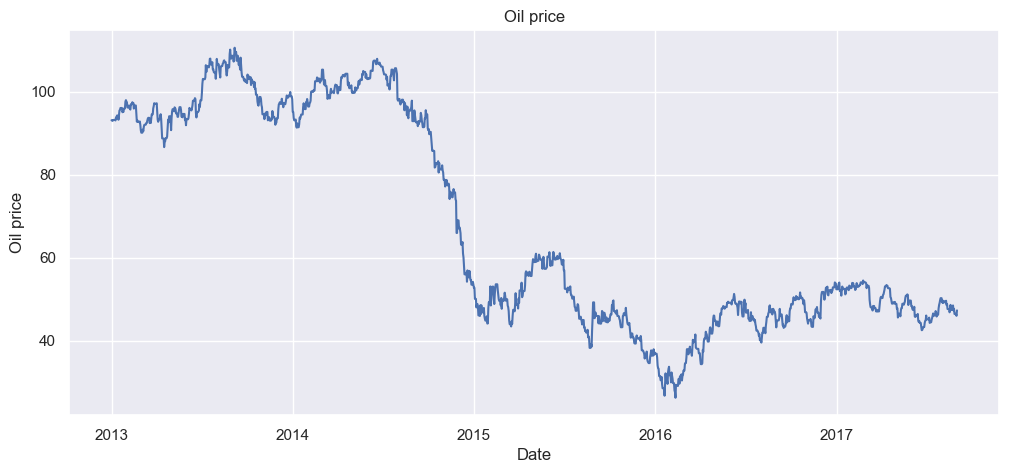

In [15]:
#### We can see there is a oil shock between 2014 and 2015. After that it slowly decreased until it hits the bottom in 2016.
### After that it stayed stable up until the last day of the dataset.
plt.figure(figsize = (12,5))
sns.lineplot(oil_df2, x = 'date', y = 'dcoilwtico')
plt.title('Oil price')
plt.xlabel('Date')
plt.ylabel('Oil price')
plt.show()

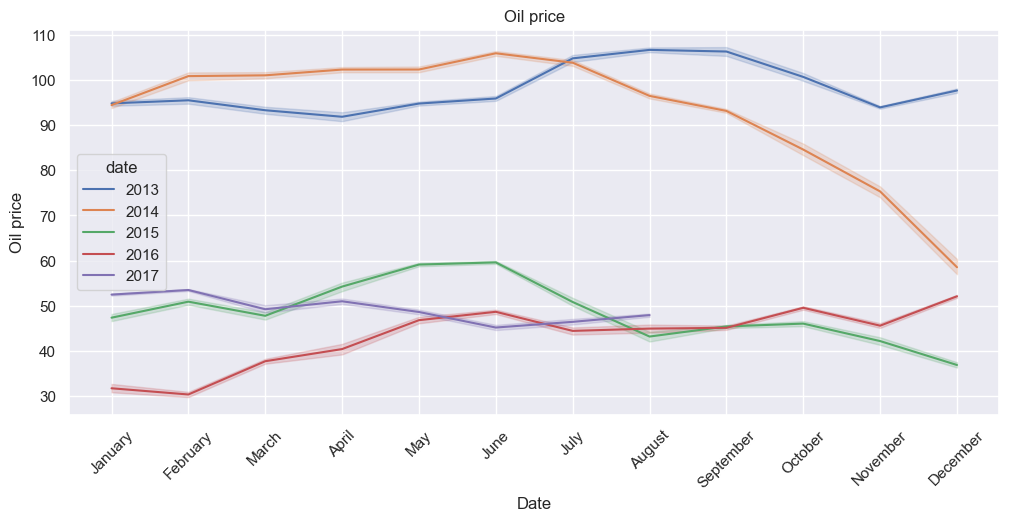

In [16]:
#### We can also check for seasonality between the years. We can't clearly see any monthly pattern, so we use can use a seasonal decompose
#### to evaluate the other seasonalities
plt.figure(figsize = (12,5))
(sns.lineplot(oil_df2, 
              x = oil_df2['date'].dt.strftime('%B'), 
              y = 'dcoilwtico', 
              hue = oil_df2['date'].dt.strftime('%Y'),
              ))
plt.title('Oil price')
plt.xlabel('Date')
plt.ylabel('Oil price')
plt.xticks(rotation = 45)
plt.show()

C:\Users\cguim\AppData\Local\Temp\ipykernel_13264\3055836855.py:11: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


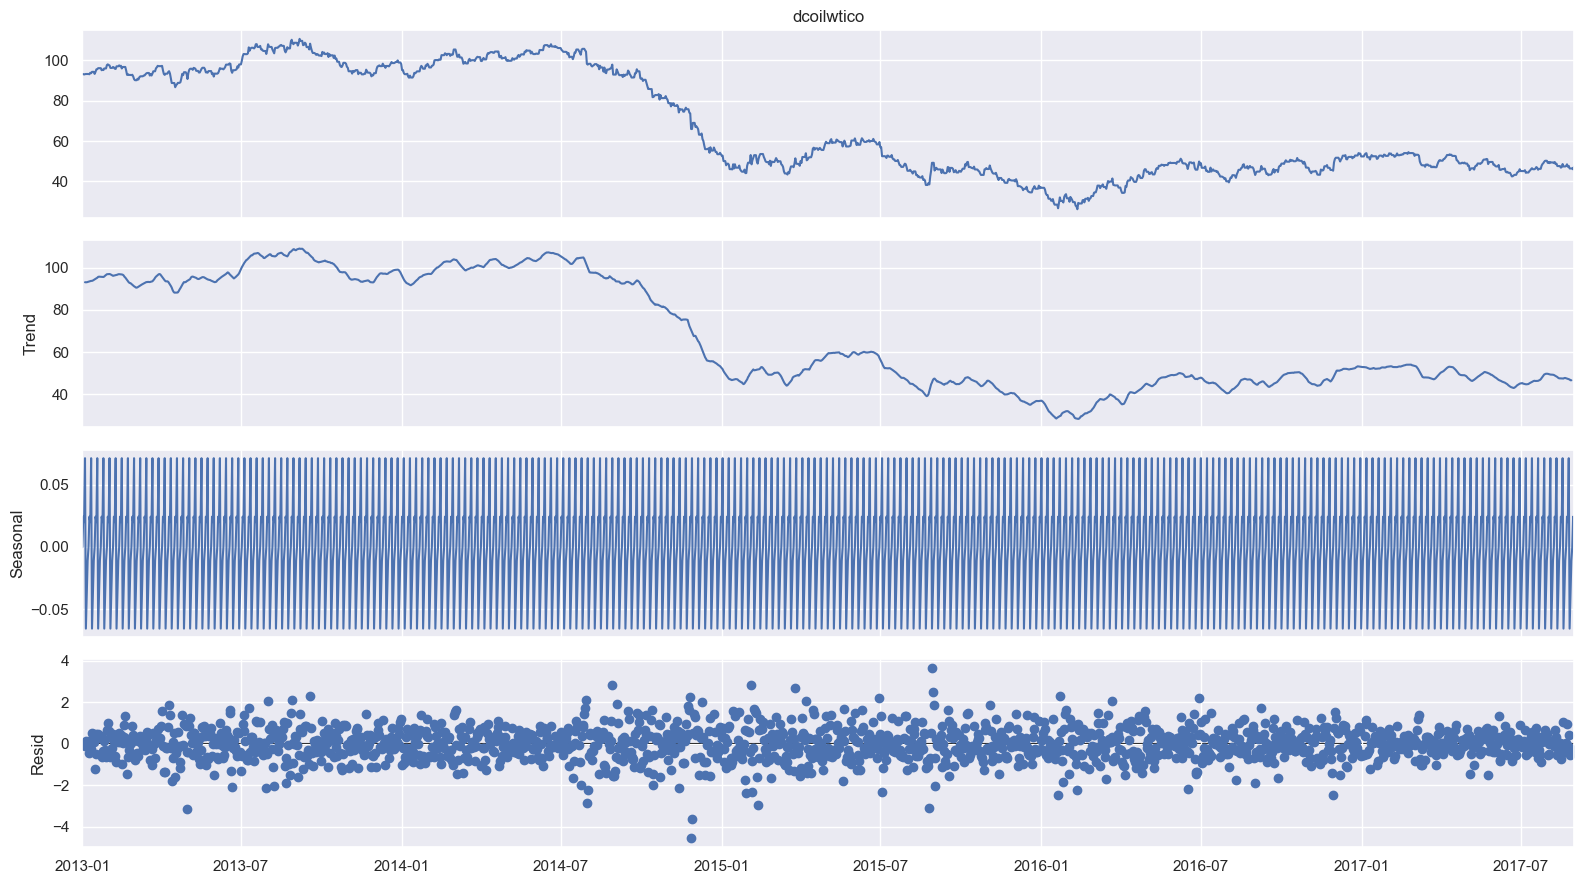

In [17]:
#Test for Seasonality
# Perform seasonal decomposition
oil_df3 = oil_df2.copy()#[oil_df2['date'].between('2013-01-01','2014-01-01')].copy()
oil_df3.set_index('date', inplace = True)
oil_df3.index.freq = 'd'
res = sm.tsa.seasonal_decompose(oil_df3.dcoilwtico)

# Create a larger figure and plot the decomposed components
fig = res.plot()
fig.set_size_inches((16,9))
fig.tight_layout()
plt.show()

#### Evaluating total sales

In [18]:
sales_df = train_df.copy()
sales_df['date'] = pd.to_datetime(sales_df['date'])

In [19]:
total_sales = sales_df.groupby(['date'], as_index = False)[['sales','onpromotion']].sum()

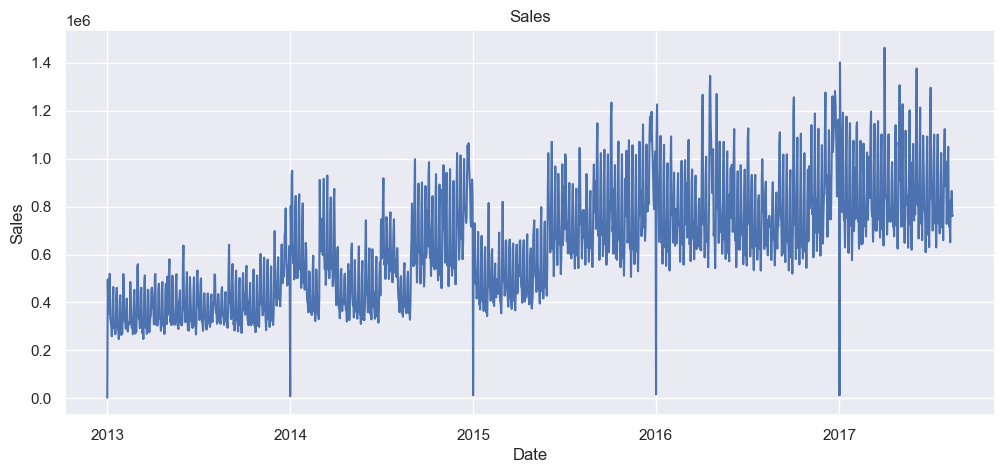

In [20]:
#### We can see there is a oil shock between 2014 and 2015. After that it slowly decreased until it hits the bottom in 2016.
### After that it stayed stable up until the last day of the dataset.
plt.figure(figsize = (12,5))
sns.lineplot(total_sales, x = 'date', y = 'sales')
plt.title('Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

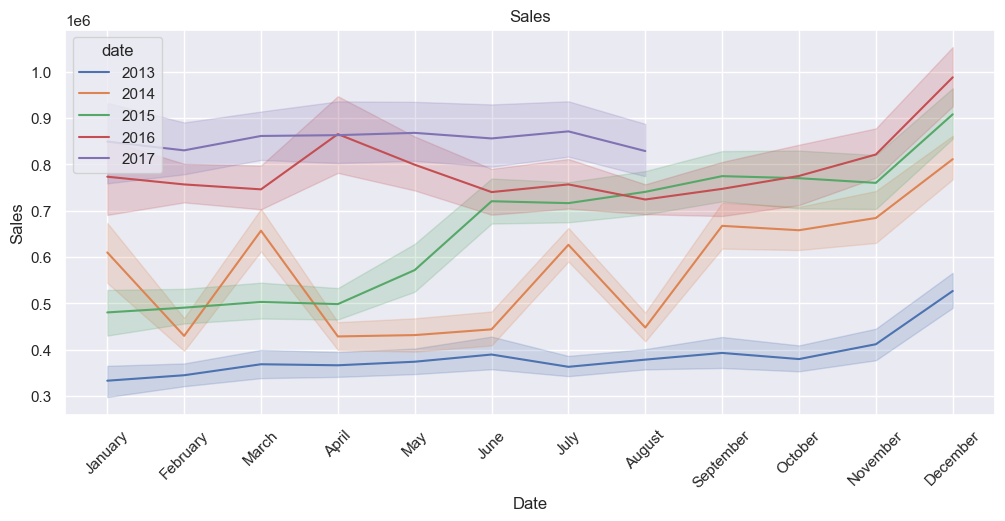

In [21]:
#### We can also check for seasonality between the years. We can't clearly see any monthly pattern, so we use can use a seasonal decompose
#### to evaluate the other seasonalities
plt.figure(figsize = (12,5))
(sns.lineplot(total_sales, 
              x = total_sales['date'].dt.strftime('%B'), 
              y = 'sales', 
              hue = total_sales['date'].dt.strftime('%Y'),
              ))
plt.title('Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.xticks(rotation = 45)
plt.show()

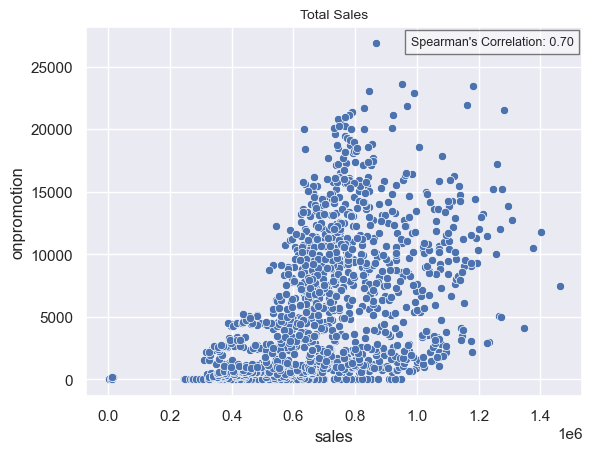

In [22]:
sns.scatterplot(data=total_sales, x='sales', y='onpromotion')

# Spearman correlation
spearman_correlation = total_sales['sales'].corr(total_sales['onpromotion'], method='spearman')
textstr = f"Spearman's Correlation: {spearman_correlation:.2f}"

# Add correlation text

plt.text(
    x=total_sales['sales'].max() * 0.67,
    y=total_sales['onpromotion'].max() * 0.995,
    s=textstr,
    fontsize=9,
    bbox=dict(facecolor='white', alpha=0.5, edgecolor='black')
)
plt.title(f"Total Sales", fontsize=10)
plt.show()

In [23]:
### Evaluating stationarity in the series -> It is a non-stationary series. We can differentiate and check again
check_stationarity(total_sales['sales'])

ADF Statistic: -2.616196
p-value: 0.089696
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568
Non-stationary


In [24]:
total_sales['dif_sales'] = total_sales['sales'].diff()
total_sales['dif_sales'].fillna(0, inplace = True)

In [25]:
### For models that require a stationary series, we can use the differentiation of the series
check_stationarity(total_sales['dif_sales'])

ADF Statistic: -11.495798
p-value: 0.000000
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568
Stationary


#### Evaluating Sales per product

In [26]:
prd_sales_df = sales_df.groupby(['date','family'], as_index=False)[['sales','onpromotion']].sum()

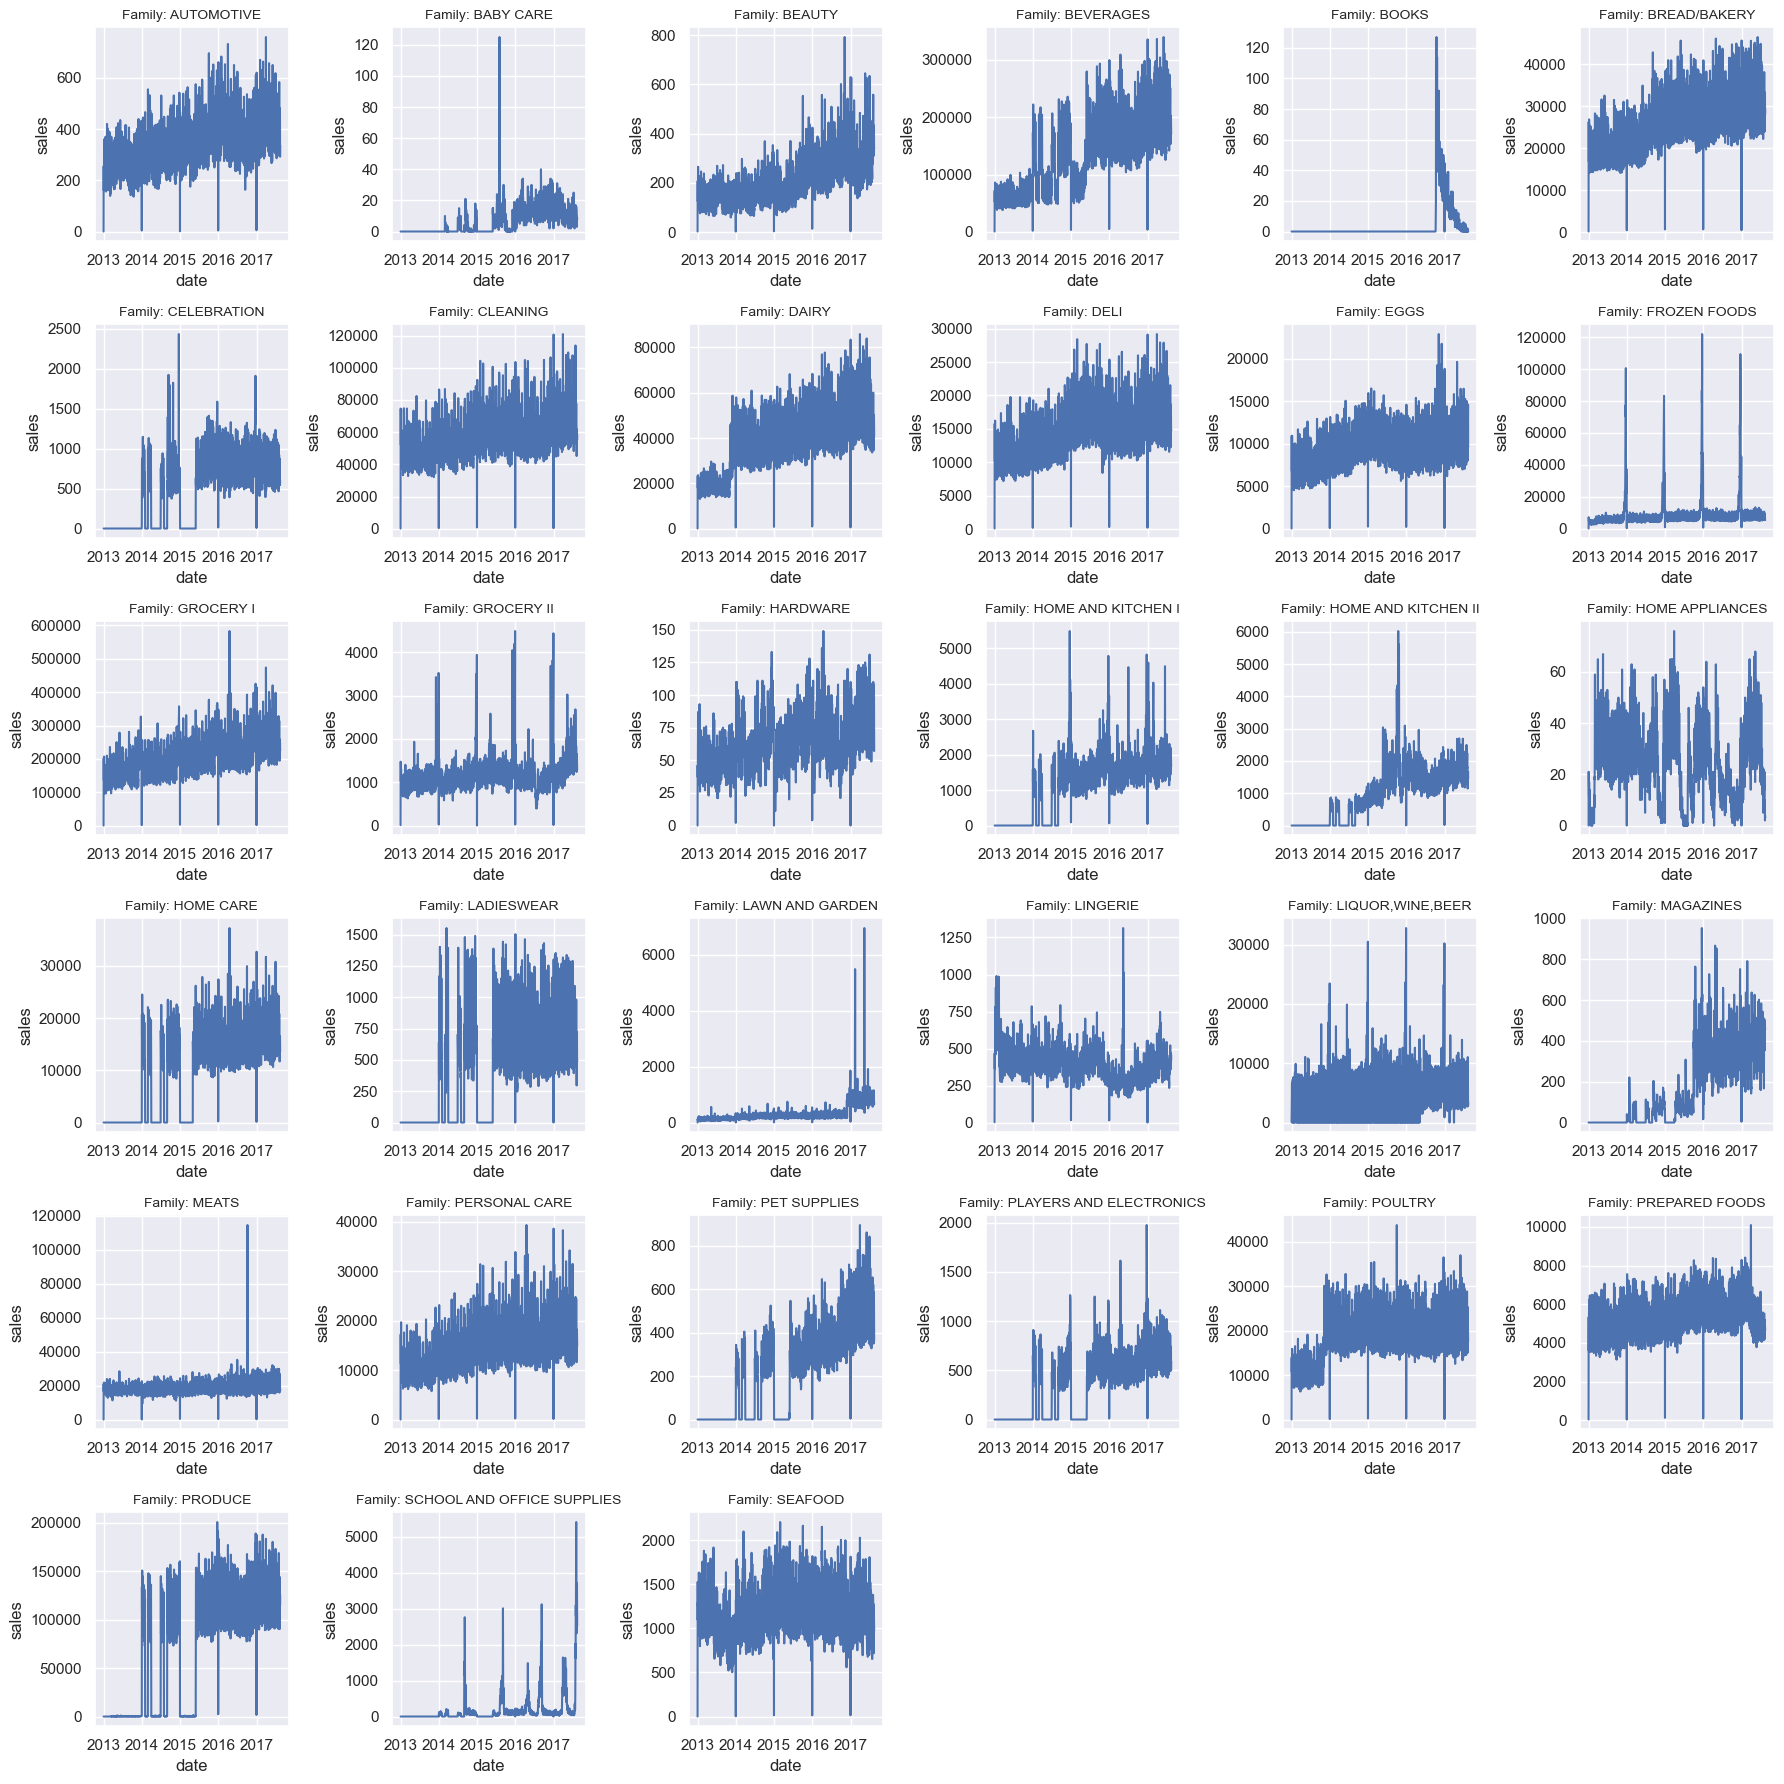

In [28]:
fig, axes = plt.subplots(6, 6, figsize=(18, 18))  # Increased figure size for better visibility
axes = axes.flatten()  # Flatten the 2D array into 1D
j = 0

for i in prd_sales_df['family'].unique():
    if j >= len(axes):
        break  # Avoid index error if more than 36 families

    temp_filter = prd_sales_df[prd_sales_df['family'] == i].copy()

    # Scatter plot
    sns.lineplot(ax=axes[j], data=temp_filter, x='date', y='sales')
    axes[j].set_title(f"Family: {i}", fontsize=10)
    j += 1

# Hide any unused subplots
for k in range(j, len(axes)):
    axes[k].axis('off')

plt.tight_layout()
plt.show()

In [29]:
#### Test commit

c:\Users\cguim\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


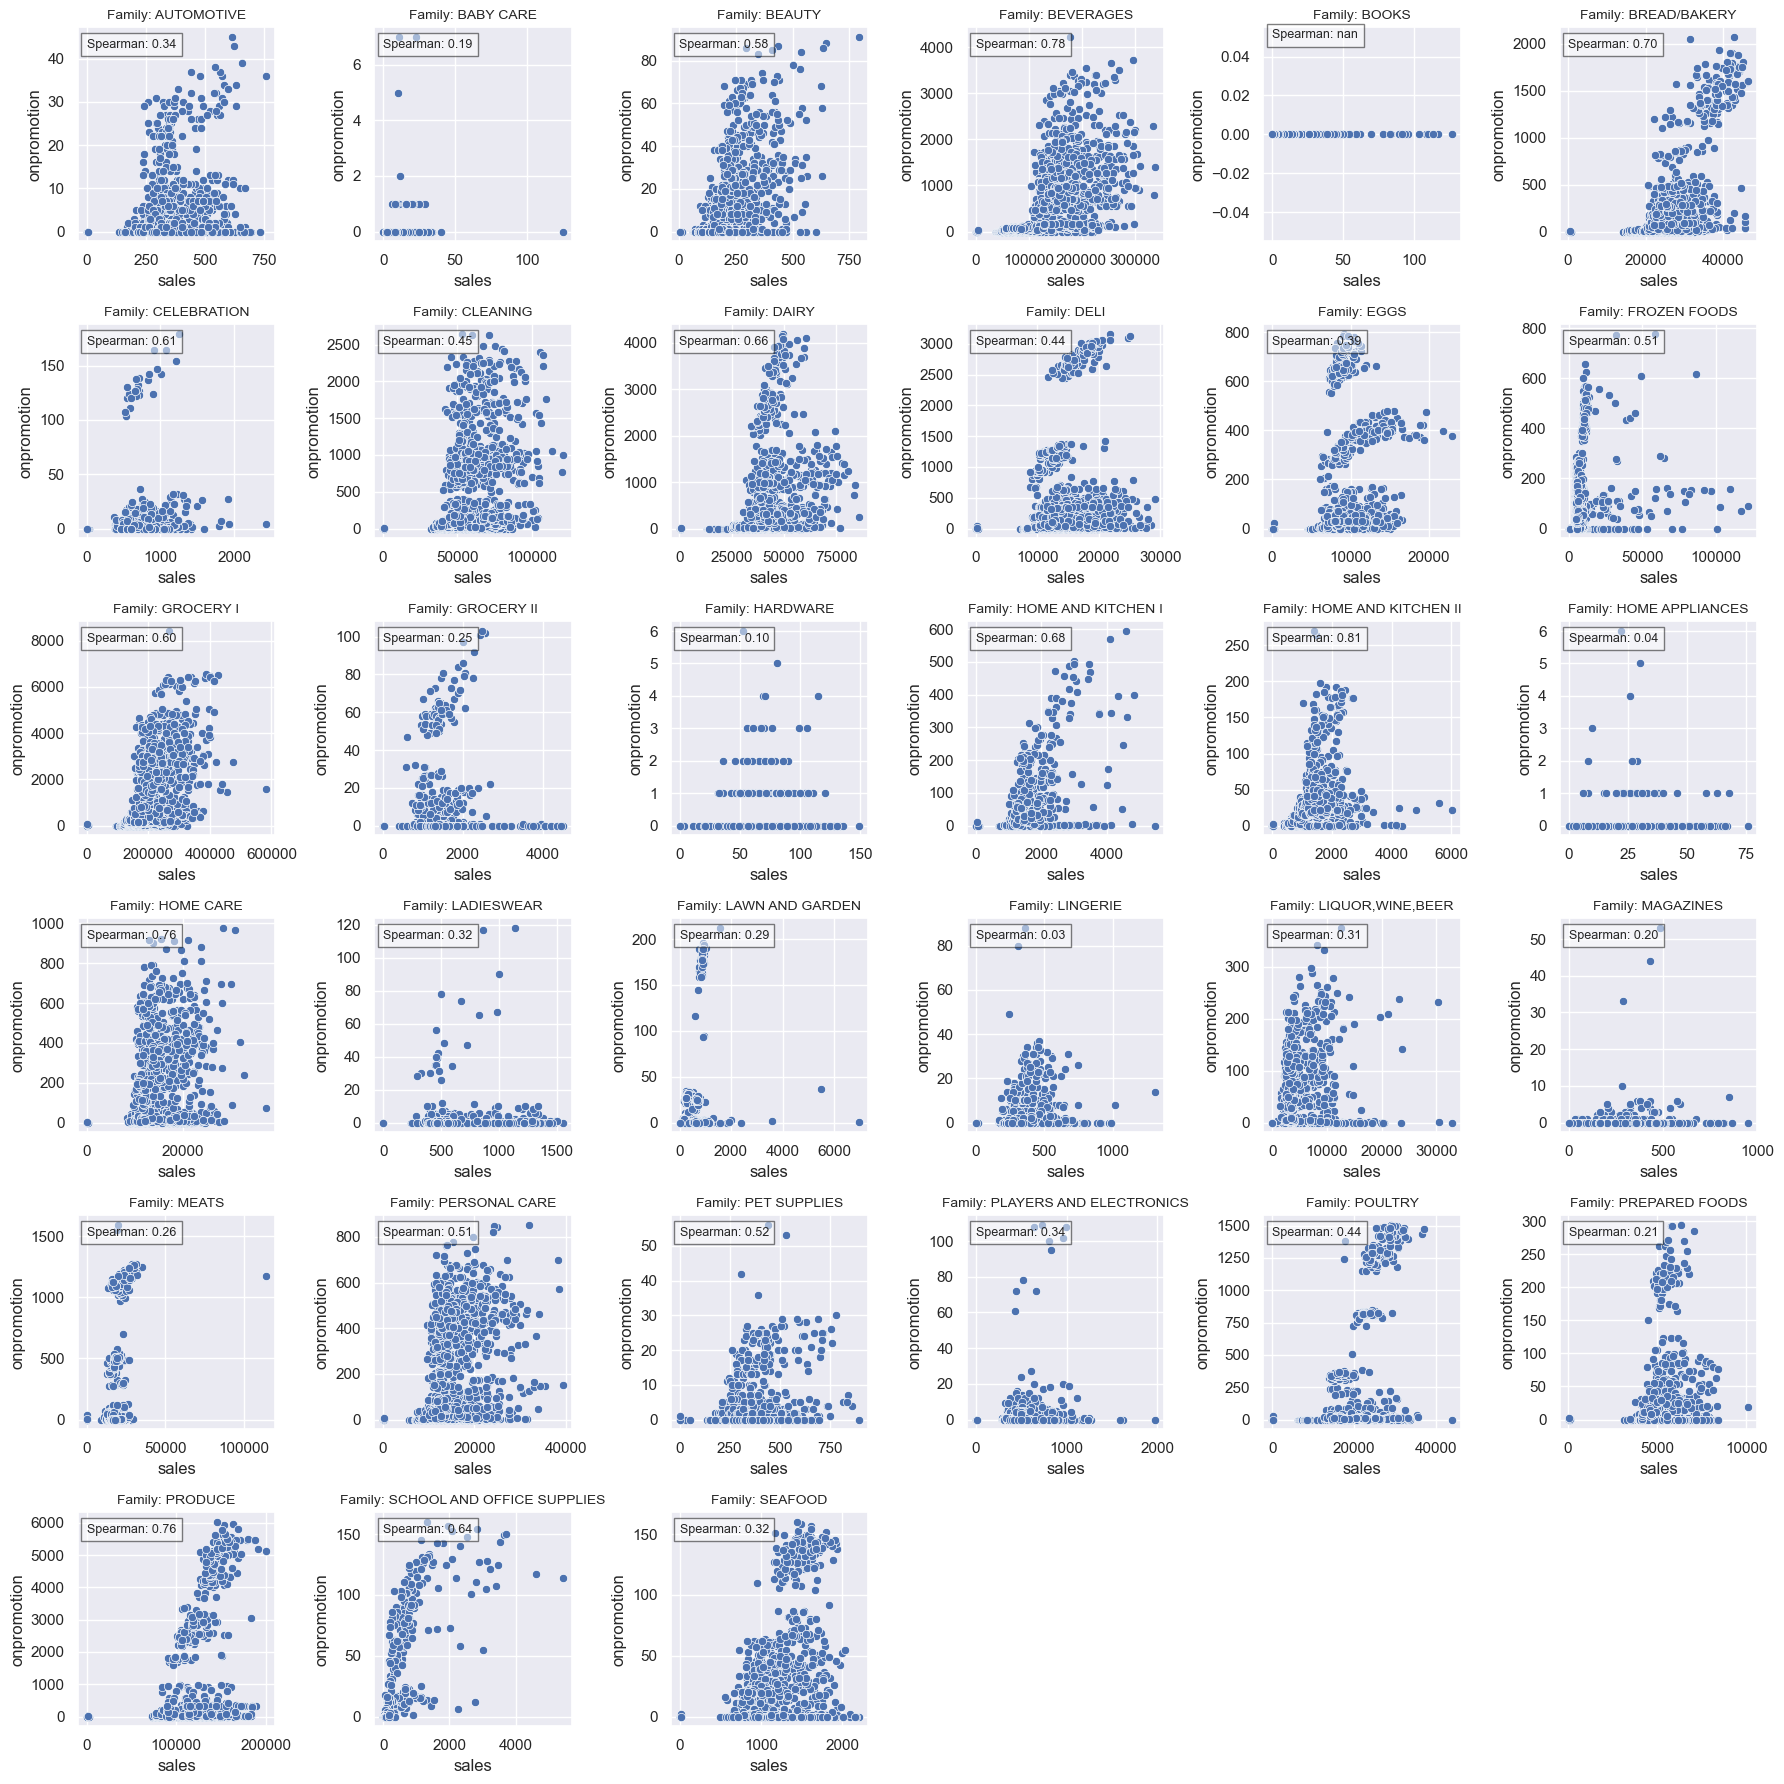

In [27]:
fig, axes = plt.subplots(6, 6, figsize=(18, 18))  # Increased figure size for better visibility
axes = axes.flatten()  # Flatten the 2D array into 1D
j = 0

for i in prd_sales_df['family'].unique():
    if j >= len(axes):
        break  # Avoid index error if more than 36 families

    temp_filter = prd_sales_df[prd_sales_df['family'] == i].copy()

    # Scatter plot
    sns.scatterplot(ax=axes[j], data=temp_filter, x='sales', y='onpromotion')

    # Spearman correlation
    spearman_correlation = temp_filter['sales'].corr(temp_filter['onpromotion'], method='spearman')
    textstr = f"Spearman: {spearman_correlation:.2f}"

    # Add correlation text
    x_pos = temp_filter['sales'].min() * 0.7
    y_min, y_max = axes[j].get_ylim()
    y_pos = y_max * 0.9

    axes[j].text(
        x=x_pos,
        y=y_pos,
        s=textstr,
        fontsize=9,
        bbox=dict(facecolor='white', alpha=0.5, edgecolor='black')
    )
    axes[j].set_title(f"Family: {i}", fontsize=10)
    j += 1

# Hide any unused subplots
for k in range(j, len(axes)):
    axes[k].axis('off')

plt.tight_layout()
plt.show()

#### Creating the final file

In [23]:
transactions_df.head(1)

,date,store_nbr,transactions
0,2013-01-01,25,770


In [24]:
stores_df.head(1)

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13


In [25]:
train_df.tail(1)

,id,date,store_nbr,family,sales,onpromotion
3000887,3000887,2017-08-15,9,SEAFOOD,16.0,0


In [26]:
test_df.head(1)

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0


In [27]:
store_prod = train_df[['store_nbr','family']].drop_duplicates().copy()
store_prod = store_prod.merge(stores_df, how = 'left', on = 'store_nbr')

In [28]:
store_prod

,store_nbr,family,city,state,type,cluster
0,1,AUTOMOTIVE,Quito,Pichincha,D,13
1,1,BABY CARE,Quito,Pichincha,D,13
2,1,BEAUTY,Quito,Pichincha,D,13
3,1,BEVERAGES,Quito,Pichincha,D,13
4,1,BOOKS,Quito,Pichincha,D,13
...,...,...,...,...,...,...
1777,9,POULTRY,Quito,Pichincha,B,6
1778,9,PREPARED FOODS,Quito,Pichincha,B,6
1779,9,PRODUCE,Quito,Pichincha,B,6
1780,9,SCHOOL AND OFFICE SUPPLIES,Quito,Pichincha,B,6
